In [ ]:
#from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q ultralytics==8.1.130 opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [ ]:
import os, json, shutil
from pathlib import Path
import pandas as pd
from ultralytics import YOLO
import cv2

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'[INFO] Using device: {device}')

[INFO] Using device: cuda


In [ ]:
# === 1. Dataset Configuration ===
# Using pre-converted YOLO format data from fish-skeleton-yolo folder
from pathlib import Path

# Path to the pre-converted YOLO dataset
BASE_DIR = Path(__file__).parent.parent.parent / 'data' / 'Couting_tracking_biomass' / 'fish-skeleton-yolo'
BASE_DIR = BASE_DIR.resolve()  # Convert to absolute path

# Output directory for training results
OUTPUT_RUNS = BASE_DIR.parent / 'runs' / 'fish_tracking_yolo'
OUTPUT_RUNS.mkdir(parents=True, exist_ok=True)

# YAML config file (already exists in fish-skeleton-yolo)
YAML_PATH = BASE_DIR / 'fishpose.yaml'

# Verify dataset paths exist
assert BASE_DIR.exists(), f"❌ Dataset directory not found: {BASE_DIR}"
assert (BASE_DIR / 'train' / 'images').exists(), f"❌ Train images not found: {BASE_DIR / 'train' / 'images'}"
assert (BASE_DIR / 'valid' / 'images').exists(), f"❌ Valid images not found: {BASE_DIR / 'valid' / 'images'}"
assert (BASE_DIR / 'test' / 'images').exists(), f"❌ Test images not found: {BASE_DIR / 'test' / 'images'}"
assert YAML_PATH.exists(), f"❌ YAML config not found: {YAML_PATH}"

print(f"✅ Using pre-converted YOLO dataset from: {BASE_DIR}")
print(f"✅ Training results will be saved to: {OUTPUT_RUNS}")

# === 2. Train YOLOv8 Pose Model ===
from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')  # or yolov8x-pose.pt for larger model

# Train model with the pre-converted dataset
results = model.train(
    data=str(YAML_PATH),
    epochs=100,
    batch=8,
    imgsz=640,
    device=device,
    project=str(OUTPUT_RUNS.parent),
    name='fish_tracking_yolo',
    patience=20,  # Early stopping patience
    save=True,
    verbose=True
)

print("[DONE] Training completed. Results saved to:", OUTPUT_RUNS)


ERROR: Ignored the following yanked versions: 8.0.129, 8.0.174, 8.0.177, 8.1.21, 8.1.31, 8.2.7, 8.2.47
ERROR: Ignored the following versions that require a different python version: 8.0.10 Requires-Python >=3.7,<=3.11; 8.0.11 Requires-Python >=3.7,<=3.11; 8.0.12 Requires-Python >=3.7,<=3.11; 8.0.13 Requires-Python >=3.7,<=3.11; 8.0.14 Requires-Python >=3.7,<=3.11; 8.0.15 Requires-Python >=3.7,<=3.11; 8.0.16 Requires-Python >=3.7,<=3.11; 8.0.17 Requires-Python >=3.7,<=3.11; 8.0.18 Requires-Python >=3.7,<=3.11; 8.0.19 Requires-Python >=3.7,<=3.11; 8.0.20 Requires-Python >=3.7,<=3.11; 8.0.21 Requires-Python >=3.7,<=3.11; 8.0.22 Requires-Python >=3.7,<=3.11; 8.0.23 Requires-Python >=3.7,<=3.11; 8.0.24 Requires-Python >=3.7,<=3.11; 8.0.25 Requires-Python >=3.7,<=3.11; 8.0.26 Requires-Python >=3.7,<=3.11; 8.0.27 Requires-Python >=3.7,<=3.11; 8.0.28 Requires-Python >=3.7,<=3.11; 8.0.29 Requires-Python >=3.7,<=3.11; 8.0.30 Requires-Python >=3.7,<=3.11; 8.0.31 Requires-Python >=3.7,<=3.11; 8.0.

[INFO] Hiển thị dự đoán trên: /content/drive/MyDrive/fish-skeleton-1/test/images/02308_jpg.rf.d0abcb6aaad3a1742ef2f5bdef12ce5a.jpg

image 1/1 /content/drive/MyDrive/fish-skeleton-1/test/images/02308_jpg.rf.d0abcb6aaad3a1742ef2f5bdef12ce5a.jpg: 640x640 5 fishs, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


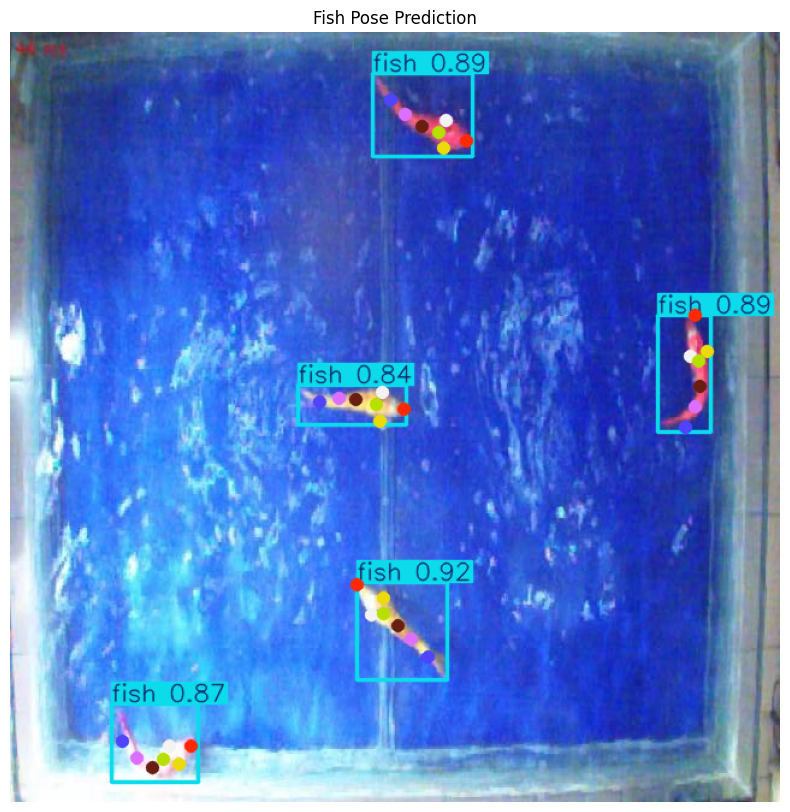

In [ ]:
# === Visualize Pose Predictions on Test Images ===
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Dataset paths
BASE_DIR = Path(__file__).parent.parent.parent / 'data' / 'Couting_tracking_biomass' / 'fish-skeleton-yolo'
BASE_DIR = BASE_DIR.resolve()
TEST_DIR = BASE_DIR / 'test' / 'images'
OUTPUT_RUNS = BASE_DIR.parent / 'runs' / 'fish_tracking_yolo'

# Path to the best trained model
best_model = OUTPUT_RUNS / 'fish_tracking_yolo' / 'weights' / 'best.pt'
assert best_model.exists(), f"❌ Model not found: {best_model}. Please run training first."

# Load trained model
model = YOLO(str(best_model))

# Get test images
test_images = sorted([f for f in TEST_DIR.iterdir() if f.suffix.lower() in ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')])

if not test_images:
    print(f"[ERROR] No image files found in {TEST_DIR}")
else:
    img_path = test_images[0]  # Use the first test image
    print(f"[INFO] Displaying pose prediction for: {img_path.name}")

    # Run pose prediction
    results = model.predict(
        source=str(img_path),
        imgsz=640,
        conf=0.25,
        save=False,
        device=device,
        show=False
    )

    # Plot results with keypoints
    res_img = results[0].plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Fish Pose Prediction")
    plt.show()


In [ ]:
# === Generate Video with Pose Detection ===
from ultralytics import YOLO
import cv2
from pathlib import Path

# Device optimization
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Device: {'GPU (CUDA)' if device == 'cuda' else 'CPU'}")

# === 1. Configure Paths ===
BASE_DIR = Path(__file__).parent.parent.parent / 'data' / 'Couting_tracking_biomass' / 'fish-skeleton-yolo'
BASE_DIR = BASE_DIR.resolve()
TEST_IMAGES_DIR = BASE_DIR / 'test' / 'images'
OUTPUT_VIDEO_DIR = BASE_DIR.parent / 'results'
OUTPUT_VIDEO_DIR.mkdir(parents=True, exist_ok=True)

# Update model path to use results from training
OUTPUT_RUNS = BASE_DIR.parent / 'runs' / 'fish_tracking_yolo'
MODEL_PATH = OUTPUT_RUNS / 'fish_tracking_yolo' / 'weights' / 'best.pt'
OUTPUT_VIDEO_PATH = OUTPUT_VIDEO_DIR / 'pose_detection_video.mp4'

assert MODEL_PATH.exists(), f"❌ Model not found: {MODEL_PATH}. Please run training first."

# Load trained model
model = YOLO(str(MODEL_PATH))

# Get sorted list of test images
image_files = sorted([f for f in TEST_IMAGES_DIR.iterdir() if f.suffix.lower() in ('.png', '.jpg', '.jpeg')])
if not image_files:
    raise ValueError(f"[ERROR] No images found in {TEST_IMAGES_DIR}")

# Get video dimensions from first image
first_img = cv2.imread(str(image_files[0]))
height, width = first_img.shape[:2]

# Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 15
out = cv2.VideoWriter(str(OUTPUT_VIDEO_PATH), fourcc, fps, (width, height))

# === 2. Run Pose Detection and Save Video ===
print("\n--- Starting Pose Detection ---")
for idx, img_path in enumerate(image_files, 1):
    frame = cv2.imread(str(img_path))

    # Run pose prediction
    results = model.predict(
        source=frame,
        imgsz=640,
        conf=0.25,
        device=device,
        verbose=False,
        show=False,
        save=False
    )

    result = results[0]
    n_fish = len(result.boxes)  # Number of detected fish

    # Plot keypoints and bounding boxes
    frame_plot = result.plot()

    # Add total fish count to frame
    cv2.putText(frame_plot, f'Total Fish: {n_fish}', (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    out.write(frame_plot)
    
    if idx % 10 == 0:
        print(f"  Processed {idx}/{len(image_files)} frames...")

out.release()
print(f"[INFO] ✅ Pose detection video saved to: {OUTPUT_VIDEO_PATH}")


✅ Thiết bị: GPU (CUDA)

--- Bắt đầu Dự đoán Pose ---
[INFO] ✅ Video Pose Estimation đã được lưu tại: /content/drive/MyDrive/fish-skeleton-1/test/pose_detection_only.mp4


In [ ]:
# === Evaluate Model on Test Set ===
from ultralytics import YOLO
import torch
from pathlib import Path

# Device optimization
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Device: {'GPU (CUDA)' if device == 'cuda' else 'CPU'}")

# === 1. Configure Paths ===
BASE_DIR = Path(__file__).parent.parent.parent / 'data' / 'Couting_tracking_biomass' / 'fish-skeleton-yolo'
BASE_DIR = BASE_DIR.resolve()

# Path to training results
OUTPUT_RUNS = BASE_DIR.parent / 'runs' / 'fish_tracking_yolo'

# Path to trained model
MODEL_PATH = OUTPUT_RUNS / 'fish_tracking_yolo' / 'weights' / 'best.pt'

# Path to dataset config (contains test split info)
YAML_PATH = BASE_DIR / 'fishpose.yaml'

# Verify required files exist
assert MODEL_PATH.exists(), f"❌ Model not found: {MODEL_PATH}. Please run training first."
assert YAML_PATH.exists(), f"❌ Dataset config not found: {YAML_PATH}"

# === 2. Load Model ===
model = YOLO(str(MODEL_PATH))

# === 3. Evaluate on Test Set ===
print("\n--- Starting Test Set Evaluation ---")

metrics = model.val(
    data=str(YAML_PATH),
    split='test',
    imgsz=640,
    conf=0.25,
    device=device,
    plots=True,
    save_json=True
)

# === 4. Print Evaluation Results ===
print("\n--- Test Set Evaluation Results ---")
print(f"✅ mAP50-95 (Bounding Box): {metrics.box.map:.4f}")
print(f"✅ mAP50 (Bounding Box): {metrics.box.map50:.4f}")
print(f"✅ mAP50-95 (Keypoints/Pose): {metrics.pose.map:.4f}")
print(f"✅ mAP50 (Keypoints/Pose): {metrics.pose.map50:.4f}")

print(f"\n[INFO] Detailed results and evaluation files saved to: {metrics.save_dir}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Thiết bị: GPU (CUDA)

--- Bắt đầu Đánh giá Chỉ số trên Tập Test ---
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-pose summary (fused): 81 layers, 3,104,129 parameters, 0 gradients, 8.4 GFLOPs
val: Fast image access ✅ (ping: 0.9±1.0 ms, read: 0.1±0.0 MB/s, size: 54.7 KB)
val: Scanning /content/drive/MyDrive/fish-skeleton-1/test/labels... 19 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 19/19 1.5it/s 13.0s
val: New cache created: /content/drive/MyDrive/fish-skeleton-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% ━━━━━━━